In [23]:
# Imports
import os, requests
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Imports
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# Figure settings
import ipywidgets as widgets # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

# Set device
DEVICE = 'cuda' #'cpu'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load big data
dir = '/content/drive/MyDrive/'
all_data = pd.read_pickle(dir + 'mice_VIP_N5.pkl')

In [3]:
#Data subsetting
all_data = all_data.query('exposure_level=="familiar"')
all_data = all_data.query('image_name!="omitted"')
#all_data = all_data.query('is_change')

# Pivot to wide (rows are stimulus presentations, columns are cell_specimen_id)
all_data = all_data.pivot(index=['mouse_id','stimulus_presentations_id','ophys_session_id','image_name'],columns='cell_specimen_id',values='dff_bc')
all_data = all_data.fillna(0)

# Get the unique mouse ids
mouse_ids = np.unique(all_data.reset_index().mouse_id.values)

Mouse #467951 SVM accuracy: 0.158


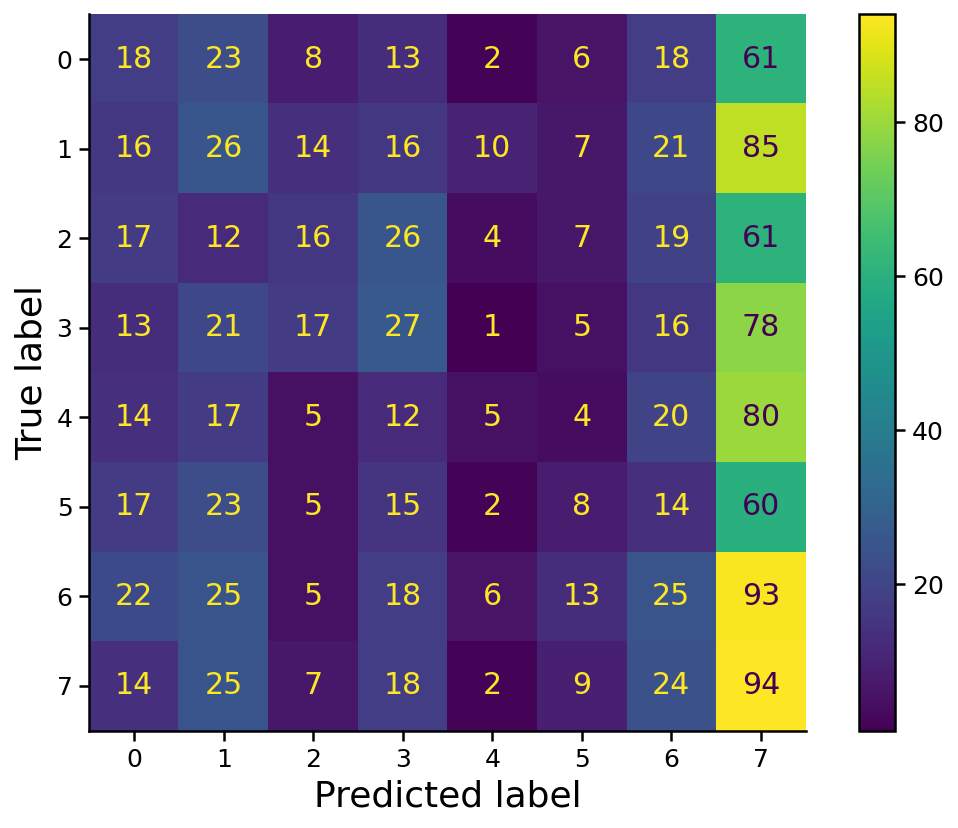

Mouse #467953 SVM accuracy: 0.314


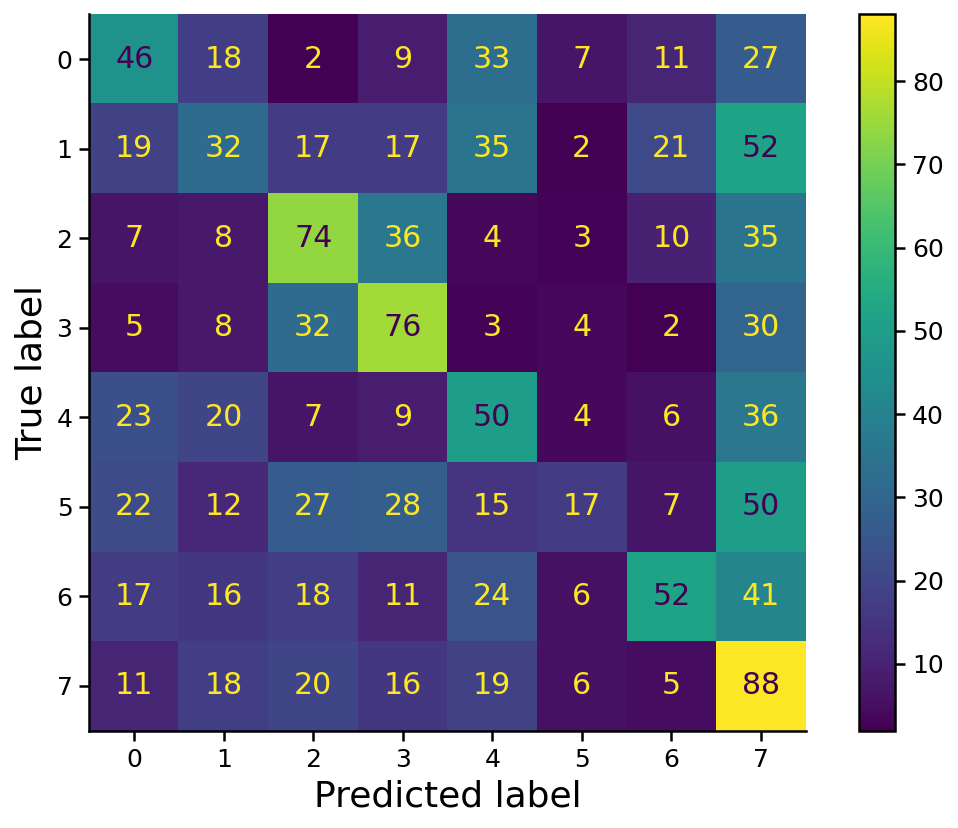

Mouse #467954 SVM accuracy: 0.179


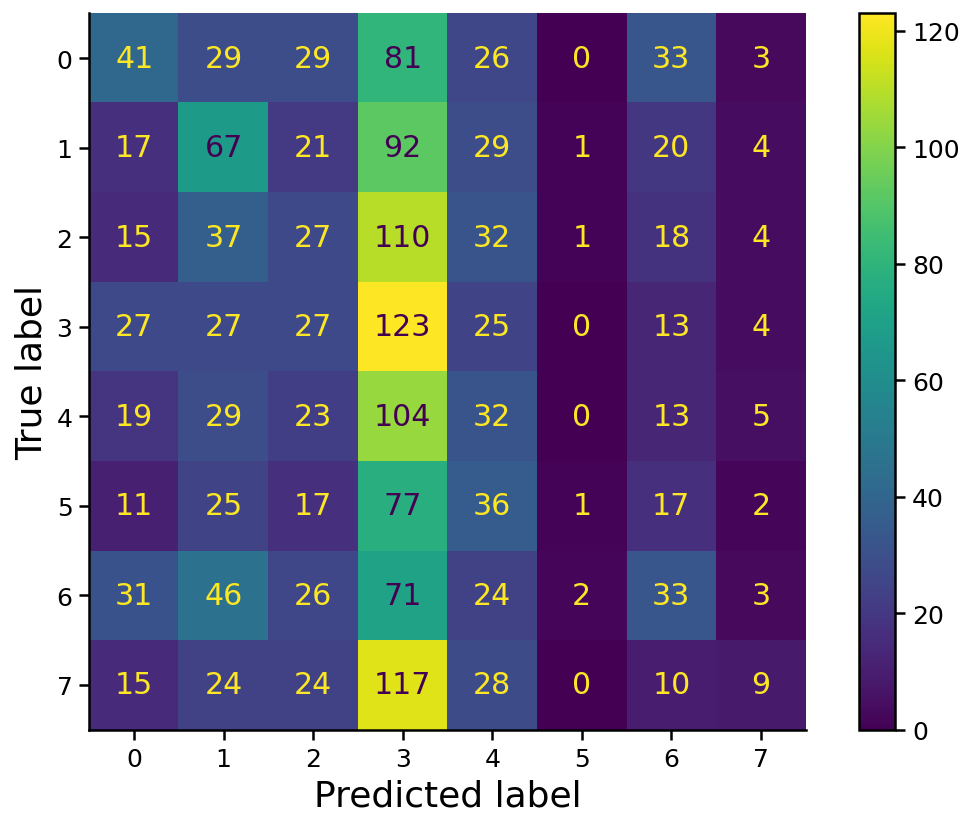

Mouse #489066 SVM accuracy: 0.18


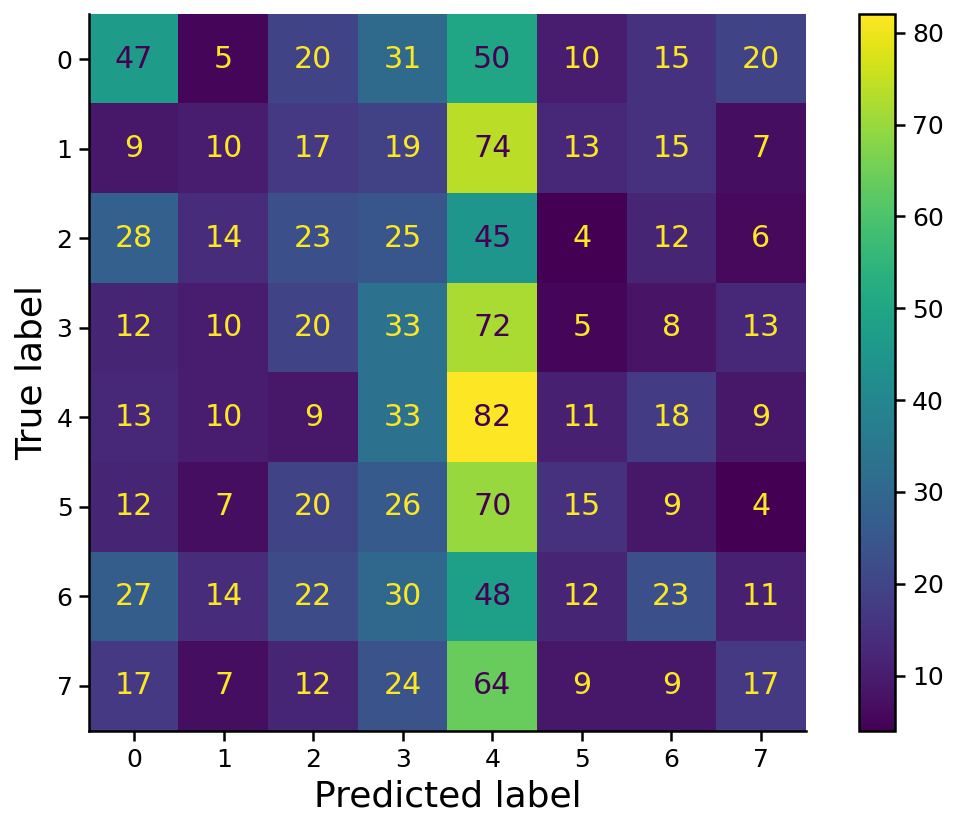

Mouse #492395 SVM accuracy: 0.229


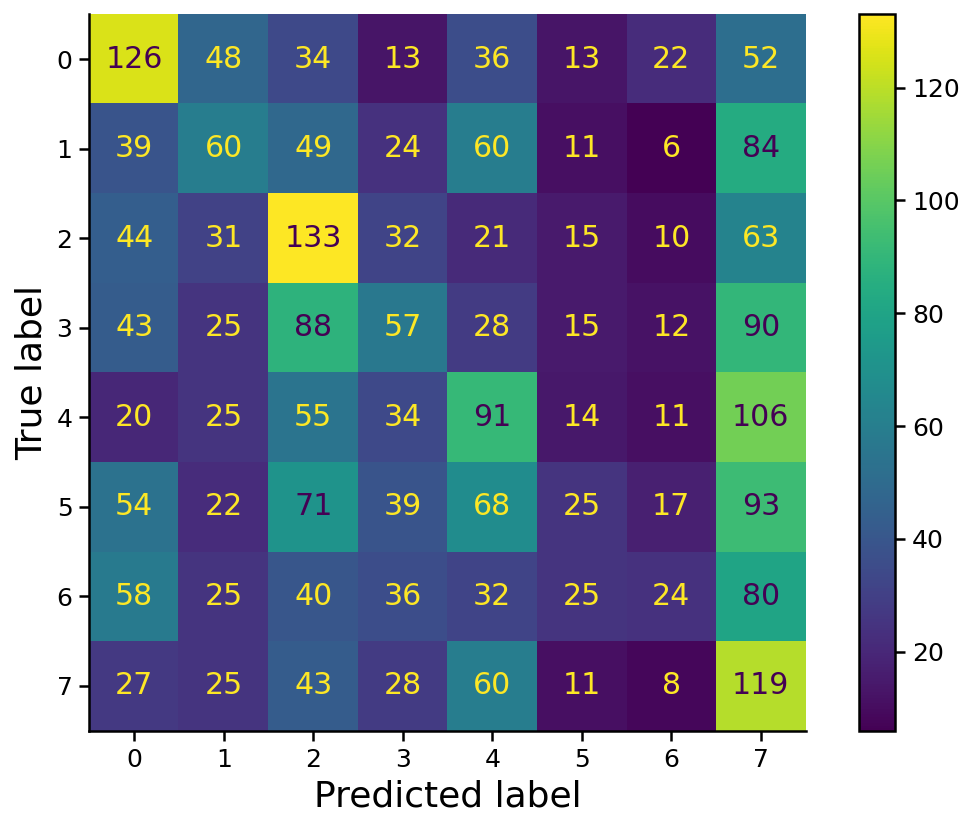

In [52]:
models = []
cms = []
for mi, mid in enumerate(mouse_ids):
  mouse_data = all_data.query('mouse_id == @mid')
  mouse_session_ids = np.unique(mouse_data.reset_index().ophys_session_id.values)
  image_names, labels = np.unique(mouse_data.reset_index().image_name.values, return_inverse='true')
  f1 = mouse_data.to_numpy()
  f1 = f1[:, np.sum(f1,axis=0)!=0]

  X_train, X_test, y_train, y_test = train_test_split(f1,labels,test_size=0.1)
  
  model = SVC(probability=True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'Mouse #{mid} SVM accuracy: {np.round(accuracy_score(y_test, y_pred),3)}')
  models.append(model)

  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  cms.append(cm)

  # X_embedded = TSNE(n_components=2).fit_transform(f1)
  # plt.figure(figsize=(16, 10))
  # ax = sns.scatterplot(
  #     x = X_embedded[:1],
  #     y = X_embedded[:1],
  #     hue="image_name",
  #     hue_order = image_names,
  #     palette = sns.color_palette()[:8],
  #     legend = "full",
  #     alpha = 0.3
  # )